## **Praktikum 1**

### **Job Sheet 10 : Recurrent Neural Network (RNN)**

**Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
import numpy as np  #untuk komputasi numerik
import tensorflow_datasets as tfds #menyediakan akses ke berbagai dataset
import tensorflow as tf

tfds.disable_progress_bar() #untuk menonaktifkan tampilan bar kemajuan (progress bar)

In [ ]:
# untuk visualisasi data
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

**penjelasan**:
- history: objek yang menyimpan informasi tentang metrik yang diukur selama pelatihan model.
- arameter ini mengacu pada metrik yang ingin divisualisasikan, seperti 'loss', 'accuracy', 'mae', 'mse'
- plt.plot() untuk menggambar grafik
- plt.xlabel() dan plt.ylabel() digunakan untuk memberi label sumbu x dan sumbu y pada grafik.

**Setup input pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

**penjelasan**  kode diatas, TensorFlow Datasets (TFDS) untuk memuat dataset 'imdb_reviews' yang terdiri dari ulasan film dari IMDB (Internet Movie Database) dengan pengaturan as_supervised=True, yang berarti data akan dimuat dalam bentuk yang sesuai untuk pelatihan model supervisi.

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"This Documentary (Now available free on Video.Google.Com) is a fantastic demonstration of the power of ordinary people to overcome injustice. Everyone must see this.<br /><br />Chavez was elected in a landslide vote in 1998. His platform was to divert the fantastic oil wealth from the 20% middle class to the 80% poor. He banned foreign drift net fishing in Venezuelan waters. He sent 10,000 Cuban doctors to the slums to treat the sick for free. He wiped out illiteracy and set up new free Universities. <br /><br />But it was his 30% tax on oil company profits that got him in trouble with the Bush administration. In 2002, while Irish film makers Kim Bartley and Donnacha O'Briain were interviewing Chavez inside the Presidential Palace about his social programs, a CIA backed coup was launched. With the cameras rolling, Chavez was captured and flown out of the country. It was announced on national TV that he had 'resigned'.<br /><br />But the poor of Venezuela didn't believe the m

**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model.

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11, 671, 150, ...,   0,   0,   0],
       [ 10,  41, 175, ...,   0,   0,   0],
       [  1,   1,   3, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

- Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
- Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This Documentary (Now available free on Video.Google.Com) is a fantastic demonstration of the power of ordinary people to overcome injustice. Everyone must see this.<br /><br />Chavez was elected in a landslide vote in 1998. His platform was to divert the fantastic oil wealth from the 20% middle class to the 80% poor. He banned foreign drift net fishing in Venezuelan waters. He sent 10,000 Cuban doctors to the slums to treat the sick for free. He wiped out illiteracy and set up new free Universities. <br /><br />But it was his 30% tax on oil company profits that got him in trouble with the Bush administration. In 2002, while Irish film makers Kim Bartley and Donnacha O'Briain were interviewing Chavez inside the Presidential Palace about his social programs, a CIA backed coup was launched. With the cameras rolling, Chavez was captured and flown out of the country. It was announced on national TV that he had 'resigned'.<br /><br />But the poor of Venezuela didn't believe the

**Buat Model**

diagram model dapat dilihat pada gambar diatas
1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
    - Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
    - Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

**penjelasan**:
- tf.keras.layers.Embedding: Lapisan embedding yang memetakan setiap token (atau kata) dalam teks ke dalam ruang vektor berdimensi 64.
- input_dim digunakan untuk menentukan jumlah token yang mungkin
- output_dim adalah dimensi dari vektor embedding yang dihasilkan.

Model ini dapat digunakan untuk tugas yang melibatkan pemrosesan teks dan prediksi nilai kontinu


Model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal.

Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN.

Untuk detailnya bisa dilihat pada Keras RNN guide

Lapisan penyematan menggunakan masking (uses masking ) untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.00028764]


Evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[0.00028764]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
391/391 [==============================] - 52s 102ms/step - loss: 0.6379 - accuracy: 0.5648 - val_loss: 0.4918 - val_accuracy: 0.7557
Epoch 2/10
391/391 [==============================] - 28s 70ms/step - loss: 0.4188 - accuracy: 0.8088 - val_loss: 0.3959 - val_accuracy: 0.8250
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3554 - accuracy: 0.8451 - val_loss: 0.3503 - val_accuracy: 0.8500
Epoch 4/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3330 - accuracy: 0.8574 - val_loss: 0.3412 - val_accuracy: 0.8599
Epoch 5/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3174 - accuracy: 0.8646 - val_loss: 0.3385 - val_accuracy: 0.8641
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3110 - accuracy: 0.8678 - val_loss: 0.3442 - val_accuracy: 0.8391
Epoch 7/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3055 - accuracy: 0.8696 - val_loss: 0.3421 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 43ms/step - loss: 0.3298 - accuracy: 0.8618
Test Loss: 0.3298164904117584
Test Accuracy: 0.8617600202560425


(0.0, 0.6550392925739288)

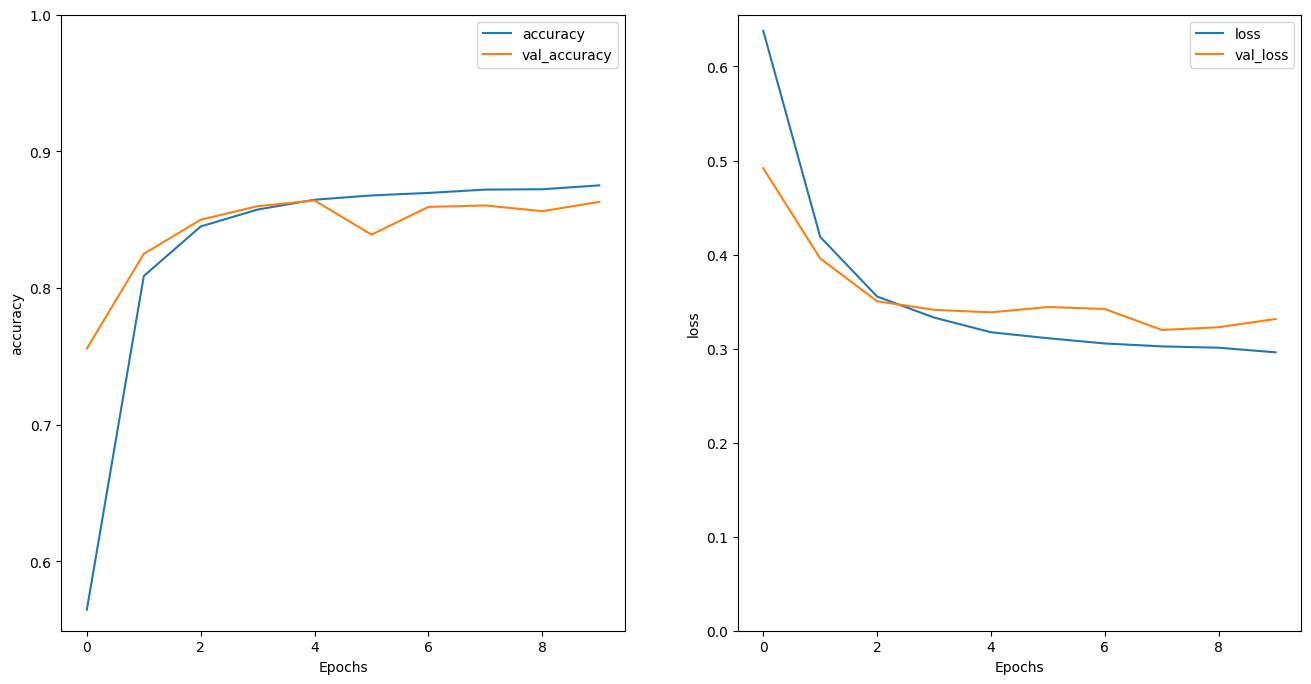

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


**Stack two or more LSTM layers**

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 80s 157ms/step - loss: 0.6090 - accuracy: 0.5972 - val_loss: 0.4140 - val_accuracy: 0.8193
Epoch 2/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3720 - accuracy: 0.8375 - val_loss: 0.3470 - val_accuracy: 0.8417
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3321 - accuracy: 0.8559 - val_loss: 0.3331 - val_accuracy: 0.8490
Epoch 4/10
391/391 [==============================] - 47s 121ms/step - loss: 0.3160 - accuracy: 0.8647 - val_loss: 0.3448 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3122 - accuracy: 0.8658 - val_loss: 0.3336 - val_accuracy: 0.8354
Epoch 6/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3035 - accuracy: 0.8695 - val_loss: 0.3304 - val_accuracy: 0.8599
Epoch 7/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3012 - accuracy: 0.8698 - val_loss: 0.3251 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 51ms/step - loss: 0.3162 - accuracy: 0.8578
Test Loss: 0.316239595413208
Test Accuracy: 0.8577600121498108


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.9666377]]


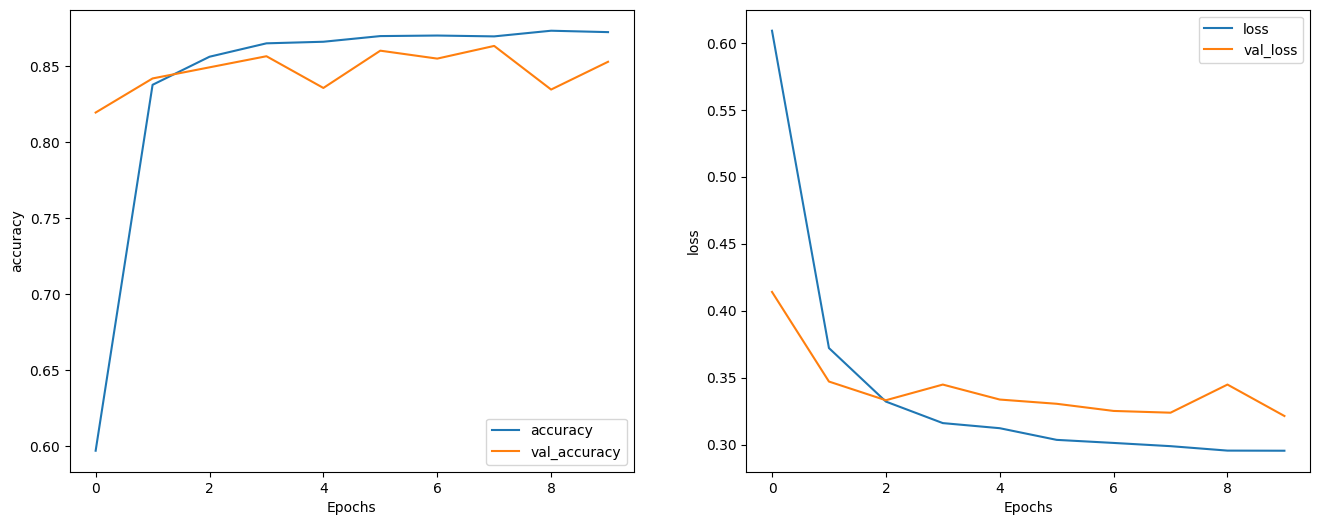

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')